In [1]:
"""
Author (in alphabetical order): Hongjian Su, Rui Li, Yingzheng Wang, Zehua Zhou
Date: 12/22/2020
"""

import keras
import h5py
import cv2
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

In [2]:
"""
DataLoader class is inspired by https://github.com/csaw-hackml/CSAW-HackML-2020/blob/master/eval.py
"""

class DataLoader:
  def __init__(self, file_path):
    self.file_path = file_path

  def load(self):
    data = h5py.File(self.file_path, "r")
    x_data = np.array(data["data"])
    self.x = x_data.transpose((0,2,3,1))
    self.y = np.array(data["label"])
  
  def preprocess(self):
    self.x = np.asarray(self.x/255, np.float64)

In [3]:
clean_data_test_filename = "drive/MyDrive/MlForCyberProject/clean_test_data.h5"
clean_data_validation_filename = "drive/MyDrive/MlForCyberProject/clean_validation_data.h5"
poisoned_data_sunglasses_filename = "drive/MyDrive/MlForCyberProject/sunglasses_poisoned_data.h5"
poisoned_data_eyebrows_multi_filename = "drive/MyDrive/MlForCyberProject/eyebrows_poisoned_data.h5"
poisoned_data_lipstick_multi_filename = "drive/MyDrive/MlForCyberProject/lipstick_poisoned_data.h5"
poisoned_data_anonymous1_filename = "drive/MyDrive/MlForCyberProject/anonymous_1_poisoned_data.h5"
sunglasses_bd_model_filename = "drive/MyDrive/MlForCyberProject/sunglasses_bd_net.h5"
multi_bd_model_filename = "drive/MyDrive/MlForCyberProject/multi_trigger_multi_target_bd_net.h5"
anonymous1_bd_model_filename = "drive/MyDrive/MlForCyberProject/anonymous_1_bd_net.h5"

test_clean = DataLoader(clean_data_test_filename)
validation_clean = DataLoader(clean_data_validation_filename)
test_poisoned_sunglasses = DataLoader(poisoned_data_sunglasses_filename)
test_poisoned_eyebrows_multi = DataLoader(poisoned_data_eyebrows_multi_filename)
test_poisoned_lipstick_multi = DataLoader(poisoned_data_lipstick_multi_filename)
test_poisoned_anonymous1 = DataLoader(poisoned_data_anonymous1_filename)

test_clean.load()
test_clean.preprocess()
validation_clean.load()
validation_clean.preprocess()
test_poisoned_sunglasses.load()
test_poisoned_sunglasses.preprocess()
test_poisoned_eyebrows_multi.load()
test_poisoned_eyebrows_multi.preprocess()
test_poisoned_lipstick_multi.load()
test_poisoned_lipstick_multi.preprocess()
test_poisoned_anonymous1.load()
test_poisoned_anonymous1.preprocess()

sunglasses_bd_model = keras.models.load_model(sunglasses_bd_model_filename)
multi_bd_model = keras.models.load_model(multi_bd_model_filename)
anonymous1_bd_model = keras.models.load_model(anonymous1_bd_model_filename)

In [4]:
class STRIP:
  def __init__(self, N, alpha, beta, gamma):
    self.N = N
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma

  def blend_image(self, img1, img2):
    return cv2.addWeighted(img1,self.alpha,img2,self.beta,self.gamma).reshape(55,47,3)

  def calculate_entropy(self, target_img, model, input_img):
    blended_img = np.zeros((self.N,55,47,3))
    random_index = np.random.choice(np.arange(len(input_img)), self.N, replace=False)
    for i in range(self.N):
      blended_img[i] = self.blend_image(target_img, input_img[random_index[i]])
    pred_label = model.predict(blended_img)
    entropy = -np.nansum(pred_label*np.log2(pred_label))
    return entropy/self.N

  def generate_entropy_distribution(self, input_img, clean_img, model):
    l = len(input_img)
    entropy_distribution = np.zeros(l)
    for i in range(l):
      target_img = input_img[i]
      entropy_distribution[i] = self.calculate_entropy(target_img, model, clean_img)
    return entropy_distribution

  def plot_histogram(self, entropy_clean, entropy_poisoned, bins, pic_name):
    plt.figure()
    plt.hist(entropy_clean, bins, weights=np.ones(len(entropy_clean))/len(entropy_clean), alpha=1, label="clean")
    plt.hist(entropy_poisoned, bins, weights=np.ones(len(entropy_poisoned))/len(entropy_poisoned), alpha=1, label="poisoned")
    plt.legend(loc="upper right", fontsize=15)
    plt.ylabel("Probability (%)", fontsize=15)
    plt.title("Normalized Entropy", fontsize=15)
    plt.tick_params(labelsize=15)
    plt.subplots_adjust(top=0.92, bottom=0.08, right=0.98, left=0.16, hspace=0, wspace=0)
    plt.savefig(pic_name, dpi=1000, pad_inches=0.0)
    plt.show()
  
  def evaluate(self, entropy_clean, entropy_poisoned, n):
    mu, sigma = norm.fit(entropy_clean)
    threshold = norm.ppf(0.05, loc=mu, scale=sigma)
    FAR = sum(x>=threshold for x in entropy_poisoned)
    FRR = sum(x<threshold for x in entropy_clean)
    return FAR/n, FRR/n

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


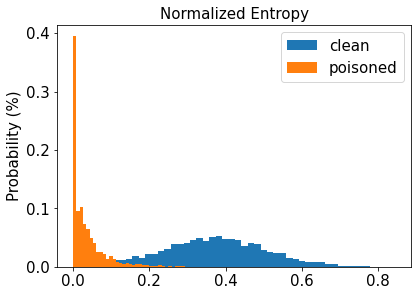

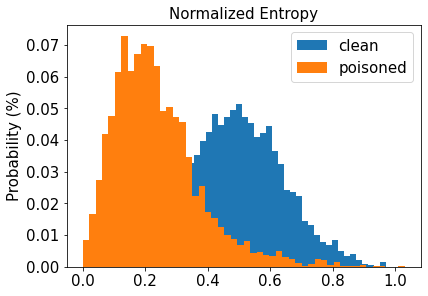

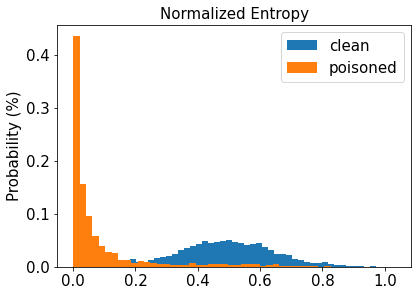

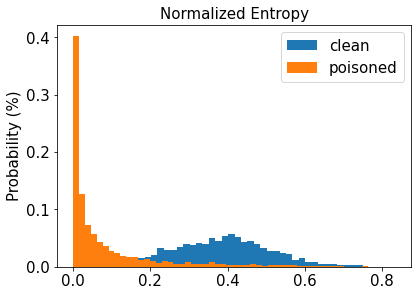

In [5]:
STRIP_filter = STRIP(50, 1.5, 1, 0)

n = 3000

entropy_clean_partial_sunglasses = STRIP_filter.generate_entropy_distribution(test_clean.x[:n], test_clean.x[:n], sunglasses_bd_model)
entropy_poisoned_partial_sunglasses = STRIP_filter.generate_entropy_distribution(test_poisoned_sunglasses.x[:n], test_clean.x[:n], sunglasses_bd_model)
entropy_clean_partial_multi = STRIP_filter.generate_entropy_distribution(test_clean.x[:n], test_clean.x[:n], multi_bd_model)
entropy_poisoned_partial_eyebrows = STRIP_filter.generate_entropy_distribution(test_poisoned_eyebrows_multi.x[:n], test_clean.x[:n], multi_bd_model)
entropy_poisoned_partial_lipstick = STRIP_filter.generate_entropy_distribution(test_poisoned_lipstick_multi.x[:n], test_clean.x[:n], multi_bd_model)
entropy_clean_partial_anonymous1 = STRIP_filter.generate_entropy_distribution(test_clean.x[:n], test_clean.x[:n], anonymous1_bd_model)
entropy_poisoned_partial_anonymous1 = STRIP_filter.generate_entropy_distribution(test_poisoned_anonymous1.x[:n], test_clean.x[:n], anonymous1_bd_model)

STRIP_filter.plot_histogram(entropy_clean_partial_sunglasses, entropy_poisoned_partial_sunglasses, 50, "STRIP_sunglasses.png")
STRIP_filter.plot_histogram(entropy_clean_partial_multi, entropy_poisoned_partial_eyebrows, 50, "STRIP_eyebrows.png")
STRIP_filter.plot_histogram(entropy_clean_partial_multi, entropy_poisoned_partial_lipstick, 50, "STRIP_lipstick.png")
STRIP_filter.plot_histogram(entropy_clean_partial_anonymous1, entropy_poisoned_partial_anonymous1, 50, "STRIP_anonymous.png")

In [6]:
FAR_sunglasses, FRR_sunglasses = STRIP_filter.evaluate(entropy_clean_partial_sunglasses, entropy_poisoned_partial_sunglasses, n)
FAR_eyebrows, FRR_eyebrows = STRIP_filter.evaluate(entropy_clean_partial_multi, entropy_poisoned_partial_eyebrows, n)
FAR_lipstick, FRR_lipstick = STRIP_filter.evaluate(entropy_clean_partial_multi, entropy_poisoned_partial_lipstick, n)
FAR_anonymous1, FRR_anonymous1 = STRIP_filter.evaluate(entropy_clean_partial_anonymous1, entropy_poisoned_partial_anonymous1, n)

print("The FAR of sunglasses BadNet with sunglasses triggers is:", FAR_sunglasses)
print("The FRR of sunglasses BadNet with sunglasses triggers is:", FRR_sunglasses)
print("The FAR of multi-trigger BadNet with eyebrows triggers is:", FAR_eyebrows)
print("The FRR of multi-trigger BadNet with eyebrows triggers is:", FRR_eyebrows)
print("The FAR of multi-trigger BadNet with lipstick triggers is:", FAR_lipstick)
print("The FRR of multi-trigger BadNet with lipstick triggers is:", FRR_lipstick)
print("The FAR of anonymous1 BadNet with anonymous1 triggers is:", FAR_anonymous1)
print("The FRR of anonymous1 BadNet with anonymous1 triggers is:", FRR_anonymous1)

The FAR of sunglasses BadNet with sunglasses triggers is: 0.04033333333333333
The FRR of sunglasses BadNet with sunglasses triggers is: 0.056666666666666664
The FAR of multi-trigger BadNet with eyebrows triggers is: 0.47833333333333333
The FRR of multi-trigger BadNet with eyebrows triggers is: 0.06533333333333333
The FAR of multi-trigger BadNet with lipstick triggers is: 0.121
The FRR of multi-trigger BadNet with lipstick triggers is: 0.06533333333333333
The FAR of anonymous1 BadNet with anonymous1 triggers is: 0.17166666666666666
The FRR of anonymous1 BadNet with anonymous1 triggers is: 0.05733333333333333
